In [26]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from xgboost import XGBRegressor,XGBClassifier,plot_importance # XGBoost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import StandardScaler,MinMaxScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, RandomizedLasso, LinearRegression,ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier  # Ensemble methods
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.feature_selection import RFE, f_regression




evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})




df=pd.read_csv('file:////Usr/local/Cellar/apache-spark/2.4.4/5003/5012/feature_hero_dcdd_riva_teama.csv')

df = df.drop(['1 - DUO_CARRY','1 - DUO_SUPPORT','1 - JUNGLE','1 - MID','1 - TOP',\
                      '2 - DUO_CARRY','2 - DUO_SUPPORT','2 - JUNGLE','2 - MID','2 - TOP',\
                      'carry_vs','support_vs','jungle_vs','mid_vs','top_vs',\
                      'teammates_jungle_mid','teammates_carry_sup'],axis=1)

print(df.head(5))

# Looking for nulls
print('null:',df[df.isnull().values==True])
print(list(df.columns))
for col in list(df.columns):
    df[col] = df[col].fillna(df[col].mean())
# Inspecting type
print(df.dtypes)

print('null:',df.isnull().any())






   matchid  T1 win  1_total_kills  2_total_kills  1 - MID_kills  \
0       10     0.0      30.446321      29.956023       6.918904   
1       11     0.0      35.101272      30.719065       7.186944   
2       12     0.0      27.706652      30.449595       6.563156   
3       14     0.0      30.369466      27.070008       6.257192   
4       15     1.0      30.580433      28.400680       7.264591   

   1 - MID_deaths  1 - MID_assists  1 - MID_dmgtoturrets  1 - MID_visionscore  \
0        5.989115         6.550073           2074.854136            10.643687   
1        7.363753         5.550697           2742.767675            10.716130   
2        5.747984         9.805233           1710.383908            12.975056   
3        5.619860         8.658318           2339.094221            12.574717   
4        5.551621         7.711706           2556.982166            12.224968   

   1 - MID_KDA  ...  2_mid_dc     1_top_dd     2_top_dd  carry_vs_score  \
0     2.248909  ...  2.012985  6063

In [27]:
###################################################################################
##########    traindata and testdata################
###################################################################################
X = df.drop(['T1 win'],axis=1).as_matrix()
Y=df['T1 win'].values
#y= np.log(y+1)

colnames=df.iloc[:,1:].columns
print(X[0:5,0:10])
'''# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=3)'''



[[1.00000000e+01 3.04463214e+01 2.99560231e+01 6.91890421e+00
  5.98911466e+00 6.55007257e+00 2.07485414e+03 1.06436865e+01
  2.24890949e+00 6.93302302e+00]
 [1.10000000e+01 3.51012721e+01 3.07190652e+01 7.18694411e+00
  7.36375295e+00 5.55069706e+00 2.74276767e+03 1.07161296e+01
  1.72977574e+00 6.37479185e+00]
 [1.20000000e+01 2.77066515e+01 3.04495950e+01 6.56315641e+00
  5.74798387e+00 9.80523256e+00 1.71038391e+03 1.29750563e+01
  2.84767483e+00 7.76467064e+00]
 [1.40000000e+01 3.03694658e+01 2.70700077e+01 6.25719242e+00
  5.61985954e+00 8.65831782e+00 2.33909422e+03 1.25747165e+01
  2.65407172e+00 5.69487179e+00]
 [1.50000000e+01 3.05804330e+01 2.84006804e+01 7.26459144e+00
  5.55162127e+00 7.71170558e+00 2.55698217e+03 1.22249676e+01
  2.69764386e+00 6.57727213e+00]]


/Users/liuxueling/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


'# Spliting X and y into train and test version\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=3)'

In [28]:
###################################################################################
##########feature selection################
###################################################################################



# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')


###################################################################################
##########feature selection################
###################################################################################
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)





###################################################################################
##########feature selection################
###################################################################################
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)












/Users/liuxueling/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


finished
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator w

In [29]:
'''
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)'''
#XGBClassifier
xgb = XGBClassifier()
xgb.fit(X,Y)
ranks["XGB"] = ranking(xgb.feature_importances_, colnames)
#RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X,Y)
ranks["RFClassifier"] = ranking(rfc.feature_importances_, colnames)

/Users/liuxueling/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    
    r[name] = round(np.mean([ranks[method][name]
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str,
                                          [ranks[method][name] for method in methods]))))


	Lasso	LinReg	RFClassifier	RFE	Ridge	XGB	rlasso/Stability	Mean
T1 win	0.0	0.0	1.0	0.0	0.0	0.15	0.0	0.16
1_total_kills	0.0	0.9	0.9	0.97	0.01	0.19	0.0	0.42
2_total_kills	0.0	1.0	0.9	0.89	0.0	0.2	0.0	0.43
1 - MID_kills	0.0	0.9	0.26	0.96	0.06	0.15	0.0	0.33
1 - MID_deaths	0.0	0.0	0.23	0.64	0.04	0.15	0.0	0.15
1 - MID_assists	0.0	0.0	0.21	0.33	0.03	0.2	0.0	0.11
1 - MID_dmgtoturrets	0.0	0.0	0.26	0.01	0.0	0.16	0.0	0.06
1 - MID_visionscore	0.0	0.0	0.29	0.17	0.0	0.16	0.0	0.09
1 - MID_KDA	0.0	0.0	0.25	0.76	0.02	0.2	0.0	0.18
1 - TOP_kills	0.0	0.9	0.46	0.95	0.01	0.21	0.0	0.36
1 - TOP_deaths	0.0	0.0	0.44	0.48	0.12	0.17	0.0	0.17
1 - TOP_assists	0.0	0.0	0.4	0.36	0.01	0.15	0.0	0.13
1 - TOP_dmgtoturrets	0.0	0.0	0.44	0.11	0.0	0.27	0.0	0.12
1 - TOP_visionscore	0.0	0.0	0.52	0.23	0.0	0.17	0.0	0.13
1 - TOP_KDA	0.0	0.0	0.4	0.4	0.12	0.23	0.0	0.16
1 - DUO_SUPPORT_kills	0.0	0.9	0.17	1.0	0.08	0.14	0.0	0.33
1 - DUO_SUPPORT_deaths	0.0	0.0	0.21	0.53	0.16	0.15	0.0	0.15
1 - DUO_SUPPORT_assists	0.0	0.0	0.18	0.43	0.05	0.

In [31]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

/Users/liuxueling/anaconda2/envs/python35/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/liuxueling/anaconda2/envs/python35/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


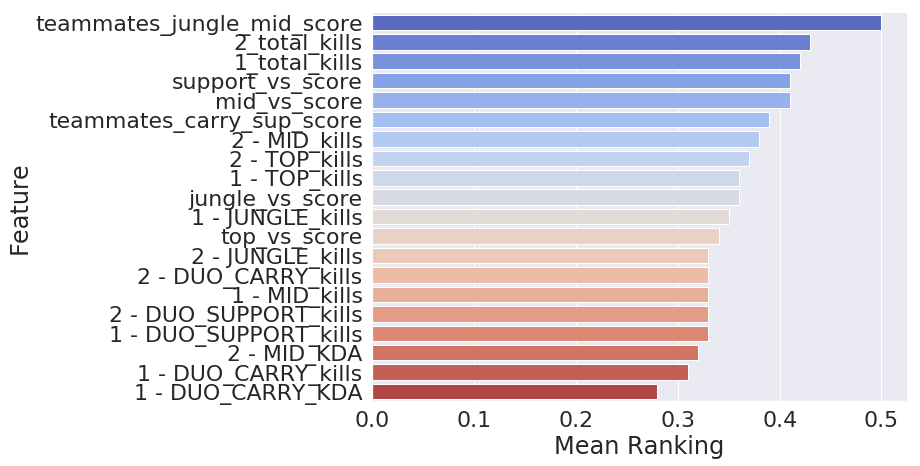

In [34]:
# Let's plot the ranking of the features
sns.set(font_scale=2)
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot[0:20], kind="bar", 
               size=7, aspect=1.9, palette='coolwarm')

In [33]:
print(meanplot[0:50])

                       Feature  Mean Ranking
38  teammates_jungle_mid_score          0.50
59               2_total_kills          0.43
24               1_total_kills          0.42
44            support_vs_score          0.41
50                mid_vs_score          0.41
7    teammates_carry_sup_score          0.39
36               2 - MID_kills          0.38
5                2 - TOP_kills          0.37
52               1 - TOP_kills          0.36
17             jungle_vs_score          0.36
3             1 - JUNGLE_kills          0.35
65                top_vs_score          0.34
23            2 - JUNGLE_kills          0.33
46         2 - DUO_CARRY_kills          0.33
54               1 - MID_kills          0.33
58       2 - DUO_SUPPORT_kills          0.33
11       1 - DUO_SUPPORT_kills          0.33
6                  2 - MID_KDA          0.32
14         1 - DUO_CARRY_kills          0.31
43           1 - DUO_CARRY_KDA          0.28
71           2 - DUO_CARRY_KDA          0.27
4         